<a href="https://colab.research.google.com/github/saketh04/Brain_Tumor_Segmentation_MAJPROJ/blob/main/Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [169]:
import os,glob
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

In [170]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

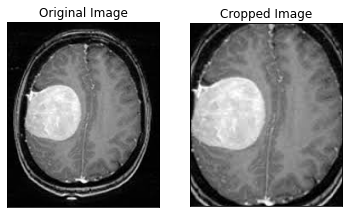

In [171]:
ex_img = cv2.imread('/content/drive/MyDrive/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [172]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [173]:
data_path = '/content/drive/MyDrive/Brain-Tumor-Detection/'

# augmented data (yes and no) contains both the original and the new generated examples
data_yes = data_path + 'yes' 
data_no = data_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([data_yes, data_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [174]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

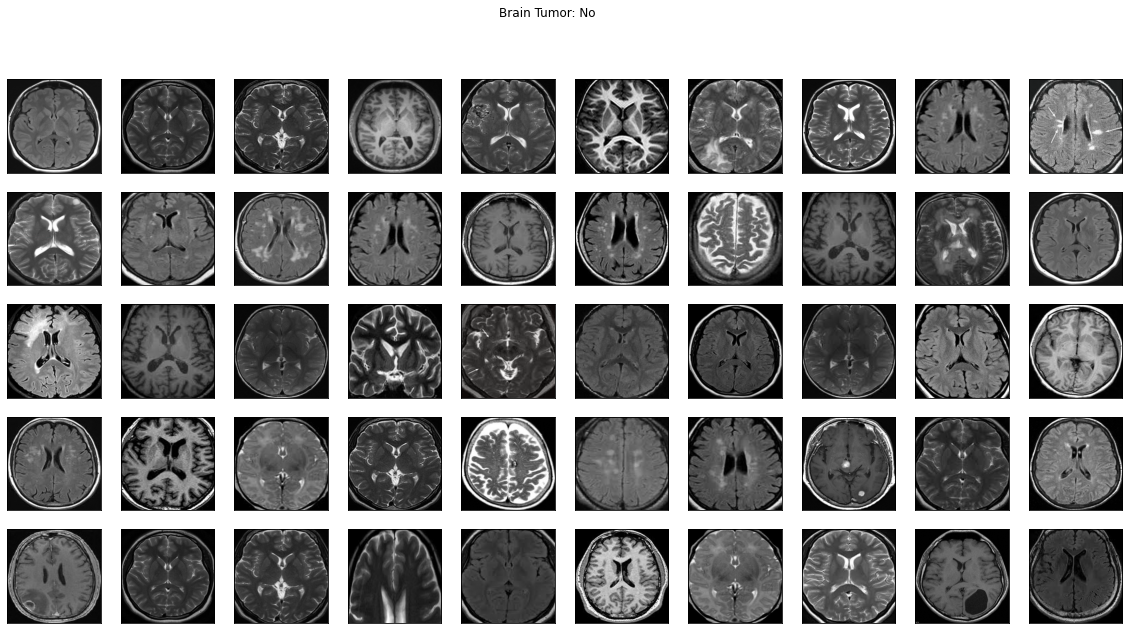

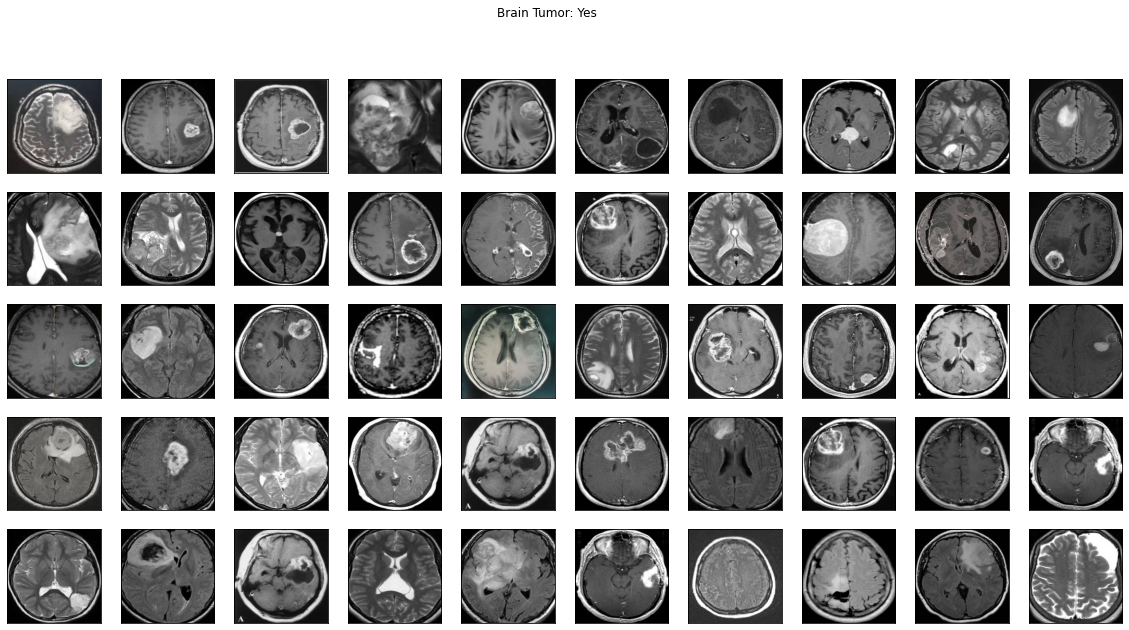

In [175]:
plot_sample_images(X, y)

In [176]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [177]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [178]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 177
number of development examples = 38
number of test examples = 38
X_train shape: (177, 240, 240, 3)
Y_train shape: (177, 1)
X_val (dev) shape: (38, 240, 240, 3)
Y_val (dev) shape: (38, 1)
X_test shape: (38, 240, 240, 3)
Y_test shape: (38, 1)


In [179]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [180]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [181]:
m1=Sequential()
m1.add(BatchNormalization(input_shape = (240,240,3)))
m1.add(Convolution2D(32, (3,3), activation ='relu', input_shape = (240, 240, 3))) 
m1.add(MaxPooling2D(pool_size=2))
m1.add(Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'))
m1.add(MaxPooling2D(pool_size=2))
m1.add(Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'))
m1.add(MaxPooling2D(pool_size=2))
m1.add(Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'))
m1.add(MaxPooling2D(pool_size=2))
m1.add(Dropout(0.25))
m1.add(Flatten()) 
m1.add(Dense(units=128,activation = 'relu'))
m1.add(Dense(units = 64, activation = 'relu'))
m1.add(Dense(units = 32, activation = 'relu'))
m1.add(Dense(units = 2, activation = 'sigmoid'))
m1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 240, 240, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_24 (Conv2D)          (None, 238, 238, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 119, 119, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 119, 119, 64)      32832     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 59, 59, 64)       0         
 g2D)                                                            
                                                      

In [182]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [183]:
m1.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [184]:
start_time = time.time()



m1.fit(X_train,y_train,epochs=70,validation_data=(X_test,y_test),verbose = 1,initial_epoch=0)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6/6 [==============================] - 1s 131ms/step - loss: 0.9190 - accuracy: 0.6497 - val_loss: 0.6971 - val_accuracy: 0.4474
Epoch 2/70
6/6 [==============================] - 1s 88ms/step - loss: 0.6603 - accuracy: 0.5819 - val_loss: 0.6845 - val_accuracy: 0.5526
Epoch 3/70
6/6 [==============================] - 1s 89ms/step - loss: 0.6702 - accuracy: 0.6271 - val_loss: 0.6824 - val_accuracy: 0.5789
Epoch 4/70
6/6 [==============================] - 1s 91ms/step - loss: 0.6662 - accuracy: 0.6441 - val_loss: 0.6785 - val_accuracy: 0.5526
Epoch 5/70
6/6 [==============================] - 1s 89ms/step - loss: 0.6481 - accuracy: 0.7232 - val_loss: 0.6774 - val_accuracy: 0.5526
Epoch 6/70
6/6 [==============================] - 1s 88ms/step - loss: 0.5801 - accuracy: 0.7175 - val_loss: 0.6583 - val_accuracy: 0.5789
Epoch 7/70
6/6 [==============================] - 1s 90ms/step - loss: 0.5235 - accuracy: 0.7571 - val_loss: 0.6682 - val_accuracy: 0.5526
Epoch 8/70
6/6 [=====================

In [185]:
history = m1.history.history

In [186]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [187]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

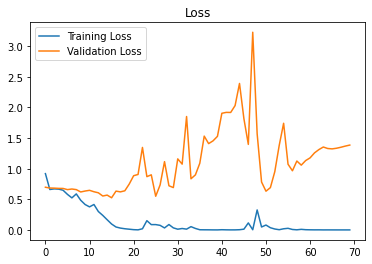

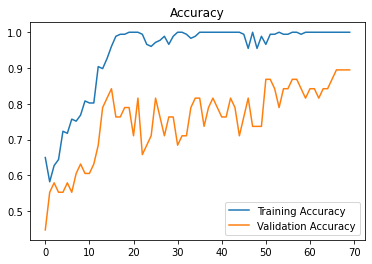

In [188]:
plot_metrics(history) 

In [189]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [190]:
data_percentage(y)

Number of examples: 253
Percentage of positive examples: 61.26482213438735%, number of pos examples: 155
Percentage of negative examples: 38.73517786561265%, number of neg examples: 98


In [191]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 177
Percentage of positive examples: 61.5819209039548%, number of pos examples: 109
Percentage of negative examples: 38.4180790960452%, number of neg examples: 68
Validation Data:
Number of examples: 38
Percentage of positive examples: 65.78947368421052%, number of pos examples: 25
Percentage of negative examples: 34.21052631578947%, number of neg examples: 13
Testing Data:
Number of examples: 38
Percentage of positive examples: 55.26315789473684%, number of pos examples: 21
Percentage of negative examples: 44.73684210526316%, number of neg examples: 17


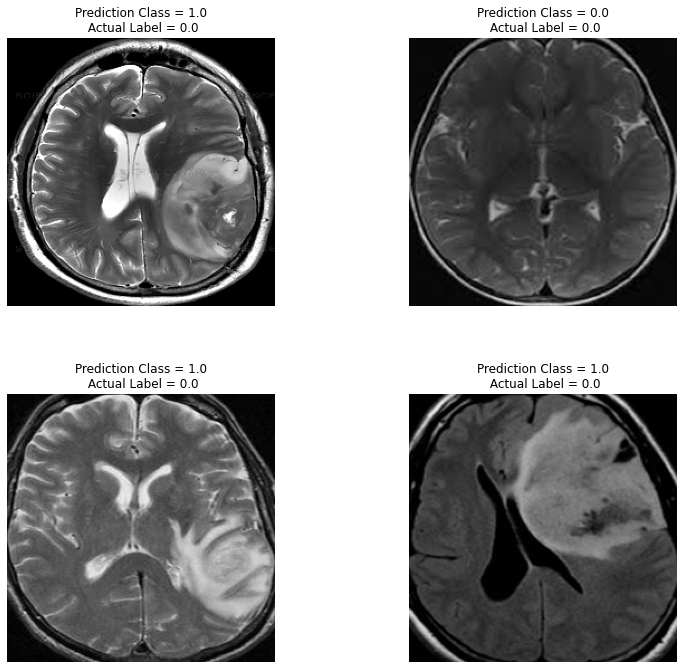

In [192]:
#y_predicted=m1.predict_classes(X_test)
#y_predicted = (m1.predict(X_test) > 0.5).astype("int32")
y_predicted = np.argmax(m1.predict(X_test), axis=-1)
y_actual=np.argmax(y_test,axis=1)
L = 2
W = 2
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()
for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"Prediction Class = {y_predicted[i]:0.1f}\n Actual Label = {y_actual[i]:0.1f}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [193]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_predicted))

              precision    recall  f1-score   support

           0       1.00      0.45      0.62        38
           1       0.00      0.00      0.00         0

    accuracy                           0.45        38
   macro avg       0.50      0.22      0.31        38
weighted avg       1.00      0.45      0.62        38



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
